In [1]:
import sys
sys.path.append('/home/alina/repos/Audio-Classification-HF/')
import os
import librosa
import torch
import numpy as np

from datasets import DatasetDict, load_dataset, load_metric, concatenate_datasets
from transformers import (
    HubertForSequenceClassification,
    HubertConfig,
    AutoModelForAudioClassification,
    AutoConfig,
    Trainer,
    TrainingArguments,
    Wav2Vec2FeatureExtractor,
    set_seed
)
from src.utils import collator

/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/alina/miniconda3/envs/hubert/lib/python3.10/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._

In [2]:
PROJECT_ROOT = "/home/alina/repos/Audio-Classification-HF"
set_seed(42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
INPUT_FIELD = "input_values"
LABEL_FIELD = "labels"

def prepare_dataset(examples, feature_extractor):
    audio_arrays = [x["array"] for x in examples["audio"]]
    input = feature_extractor(
        audio_arrays, 
        sampling_rate=16000, 
        padding=True, 
        return_tensors="pt"
    )

    examples[INPUT_FIELD] = input.input_values.to(device)
    examples[LABEL_FIELD] = examples[ "emotion"]  # colname MUST be labels as Trainer will look for it by default

    return examples



In [49]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")
model_path = "./results/hubert/06_exp_dusha/checkpoint-1600"

config = HubertConfig.from_pretrained(model_path)

model = HubertForSequenceClassification.from_pretrained(
    model_path,
    config=config,  # because we need to update num_labels as per our dataset
 # to avoid classifier size mismatch from from_pretrained.
).to(device)
# model = model.to(device)

In [34]:
dataset = load_dataset("xbgoose/dusha")

ds_ang = dataset['train'].filter(lambda example: example["emotion"] == "angry")
ds_hap = dataset['train'].filter(lambda example: example["emotion"] == "positive")
ds_sad = dataset['train'].filter(lambda example: example["emotion"] == "sad")
ds_neu = dataset['train'].filter(lambda example: example["emotion"] == "neutral")
ds_oth = dataset['train'].filter(lambda example: example["emotion"] == "other")

ds_a = ds_ang.shard(num_shards=4, index=0)
ds_h = ds_hap.shard(num_shards=4, index=0)
ds_s = ds_sad.shard(num_shards=6, index=0)
ds_n = ds_neu.shard(num_shards=30, index=0)
ds_o = ds_oth

ds = concatenate_datasets([ds_a, ds_h, ds_s, ds_n, ds_o])

train_testvalid = ds.train_test_split(shuffle=True, test_size=0.1, seed=42)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)


In [35]:
ds = DatasetDict(
    {
        "train": train_testvalid["train"],
        "test": test_valid["test"],
        "val": test_valid["train"],
    }
)

In [40]:
ds = ds.class_encode_column("emotion")

In [41]:
ds['test'].features['emotion'].names

['angry', 'neutral', 'other', 'positive', 'sad']

In [42]:
ds

DatasetDict({
    train: Dataset({
        features: ['audio', 'emotion'],
        num_rows: 14171
    })
    test: Dataset({
        features: ['audio', 'emotion'],
        num_rows: 788
    })
    val: Dataset({
        features: ['audio', 'emotion'],
        num_rows: 787
    })
})

In [43]:
encoded_dataset = ds.map(prepare_dataset, 
                              fn_kwargs={"feature_extractor": feature_extractor}, 
                              remove_columns=["audio"],
                              batched=True, 
                              batch_size=4)

In [50]:
from tqdm import tqdm

model.eval()
preds = []
for sample in tqdm(encoded_dataset['test']):
    logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
    # print(logits)
    predictions = torch.argmax(logits, dim=-1)
    # print(predictions)  
    predicted_emotion = config.id2label[predictions.cpu().data.numpy()[0]]
    preds.append(predicted_emotion)
    # print(predicted_emotion)

100%|██████████| 788/788 [01:09<00:00, 11.42it/s]


In [51]:
gts  = [config.id2label[gt] for gt in encoded_dataset['test']['labels']]

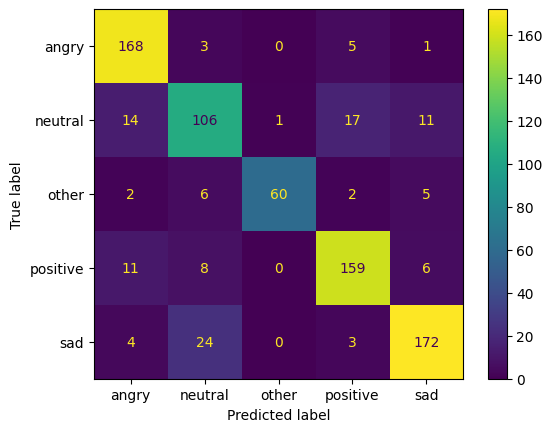

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gts, preds, labels=list(config.label2id.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(config.label2id.keys()))
disp.plot()

plt.show()

In [53]:
from sklearn.metrics import classification_report

print(classification_report(gts, preds, target_names=list(config.label2id.keys())))

              precision    recall  f1-score   support

       angry       0.84      0.95      0.89       177
     neutral       0.72      0.71      0.72       149
       other       0.98      0.80      0.88        75
    positive       0.85      0.86      0.86       184
         sad       0.88      0.85      0.86       203

    accuracy                           0.84       788
   macro avg       0.86      0.83      0.84       788
weighted avg       0.85      0.84      0.84       788



: 